# **SPEECH EMOTION RECOGNITION**


**TABLE OF CONTENTS**
* INTRODUCTION
* EXPLORATORY DATA ANALYSIS (EDA)
* DATA AUGMENTATION
* FEATURE EXTRACTION
* MODEL

# INTRODUCTION

**PROBLEM STATEMENT**

The purpose is to recognize the emotion and affective state of the speaker from his/her speech signal. 

**DATA SOURCE USED**

We have used the RAVDESS dataset in this project.It is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders.
Here's the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

# EXPLORATORY DATA ANALYSIS

The key features of the audio data are namely, MFCC (Mel Frequency Cepstral Coefficients), Mel Spectrogram and Chroma.

* MFCC (Mel Frequency Cepstral Coefficients)- 
MFCC is taken on a Mel scale which is a scale that relates the perceived frequency of a tone to the actual measured frequency. It scales the frequency in order to match more closely what the human ear can hear. The envelope of the temporal power spectrum of the speech signal is representative of the vocal tract and MFCC accurately represents this envelope.


* Mel Spectrogram- 
A Fast Fourier Transform is computed on overlapping windowed segments of the signal, and we get what is called the spectrogram. This is just a spectrogram that depicts amplitude which is mapped on a Mel scale.

* Chroma- 
A Chroma vector is typically a 12-element feature vector indicating how much energy of each pitch class is present in the signal in a standard chromatic scale.

For the EDA we have used MFCC and Mel Spectogram

In [69]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [128]:
# path to the directory
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [129]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

female_calm        96
male_calm          96
female_sad         96
female_fear        96
female_happy       96
female_surprise    96
male_angry         96
male_sad           96
female_angry       96
male_surprise      96
male_happy         96
male_fear          96
male_disgust       96
female_disgust     96
male_neutral       48
female_neutral     48
Name: labels, dtype: int64

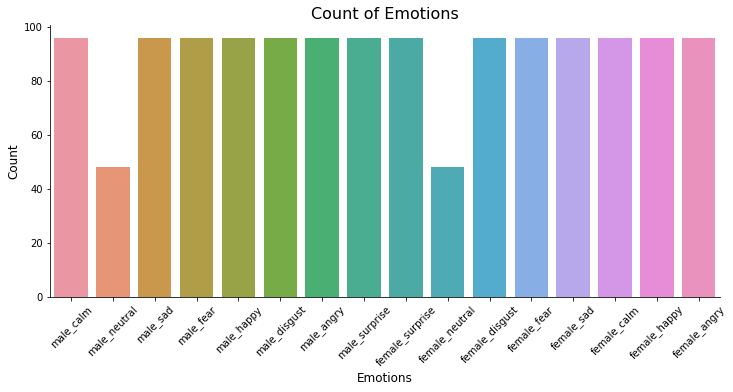

In [130]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAV_df.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Now, we will compare mel spectograms of male and female neutral audio clips.

In [131]:
# MALE NEUTRAL
fname1=RAV+'Actor_01/03-01-01-01-01-01-01.wav'
data, sr = librosa.load(fname1)
ipd.Audio(fname1) 


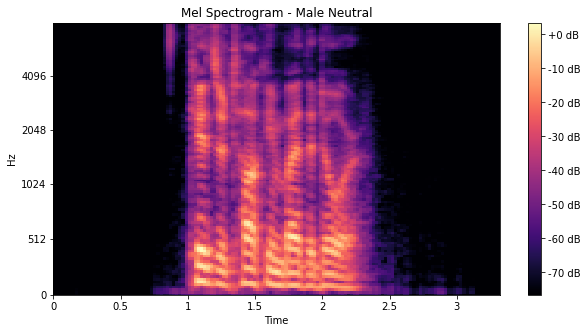

In [132]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.colorbar(format='%+2.0f dB');

In [133]:
# FEMALE NEUTRAL
fname2=RAV+'Actor_14/03-01-01-01-01-01-14.wav'
data, sr = librosa.load(fname2)
ipd.Audio(fname2) 

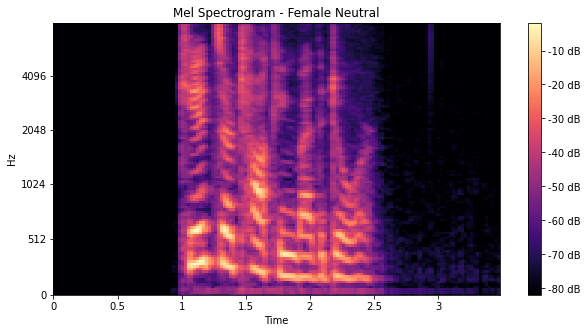

In [134]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Neutral')
plt.colorbar(format='%+2.0f dB');

Next, we compare the waveplots of happy and fearful tracks

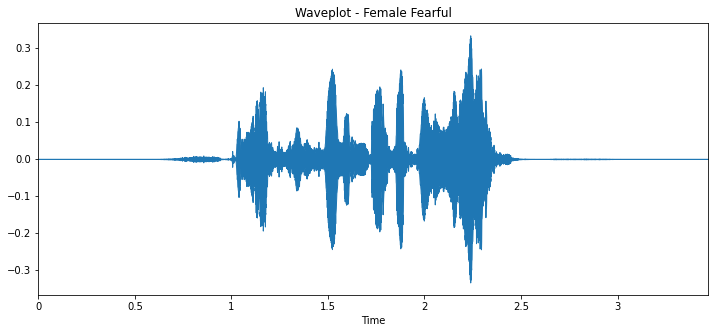

In [135]:
# Pick a fearful track
fname3 = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sr = librosa.load(fname3)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Female Fearful')
# Lets play the audio 
ipd.Audio(fname3)

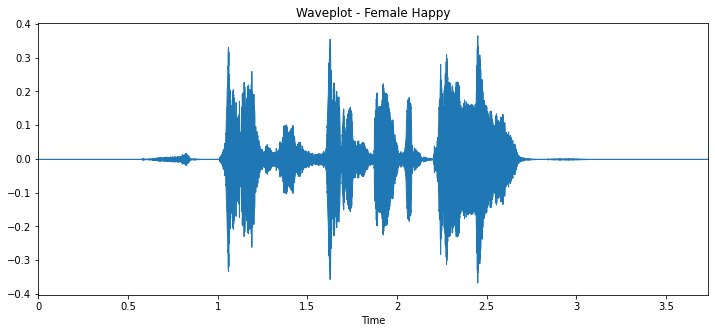

In [136]:
# Pick a happy track
fname4 = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sr = librosa.load(fname4)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Female Happy')

# Lets play the audio 
ipd.Audio(fname4)

For the happy track it actually felt like it was a fearful tone at the start, up until the end. We had to play it 3 or 4 times to finally be convienced that it is indeed a happy sound. Looking at the wave plot between the 2 files, we noticed the only difference is the amplitute wherein this happy track has a higher amplituted at various points.


Next, we compare the MFCC feature for male and female angry audio clips

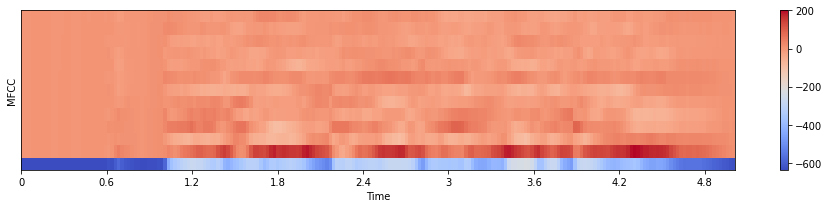

In [137]:
# Gender - Female; Emotion - Angry 
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

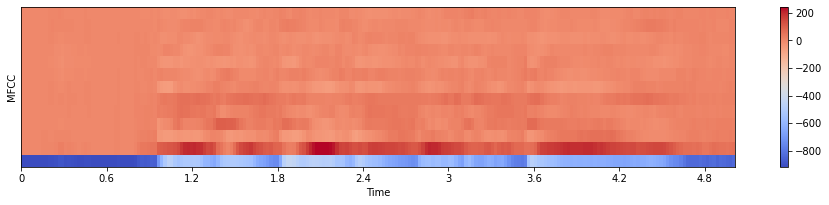

In [138]:
# Gender - Male; Emotion - Angry 
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

216
216


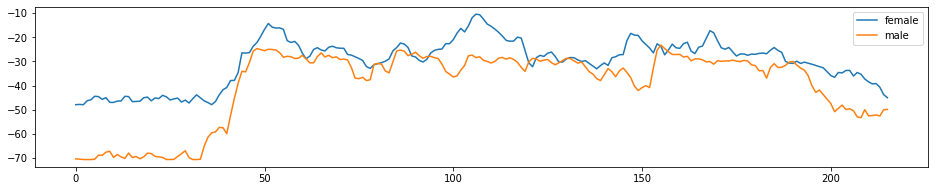

In [139]:
# Gender - Female; Emotion - angry
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Gender - Male; Emotion - angry
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

For the same sentence being uttered, there is a clear distint difference between male and female in that females tends to have a higher pitch.

# DATA AUGMENTATION

* Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
* To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
* The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
In order to this to work adding the perturbations must conserve the same label as the original training sample.

In [140]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [141]:
# Trying different functions above
path = np.array(RAV_df['path'])[303]
data, sample_rate = librosa.load(path)

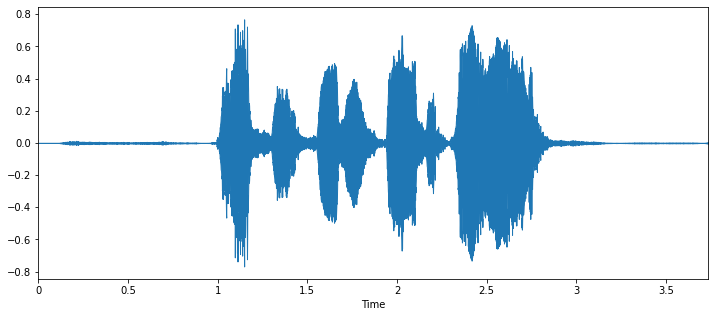

In [142]:
# NORMAL AUDIO
plt.figure(figsize=(12, 5))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

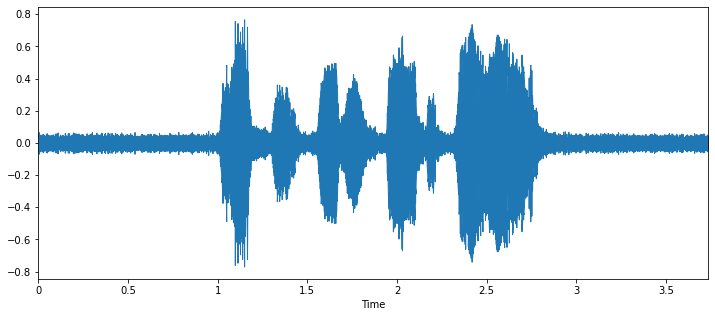

In [143]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

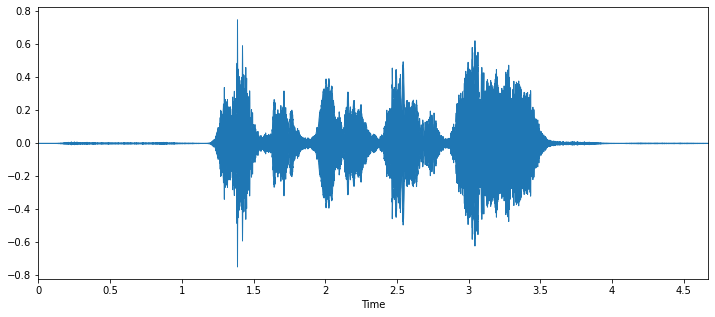

In [144]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

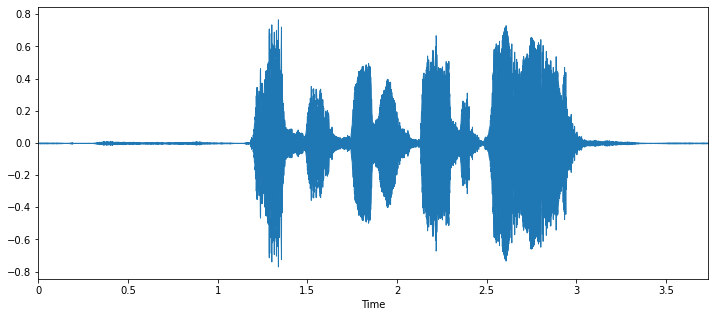

In [145]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

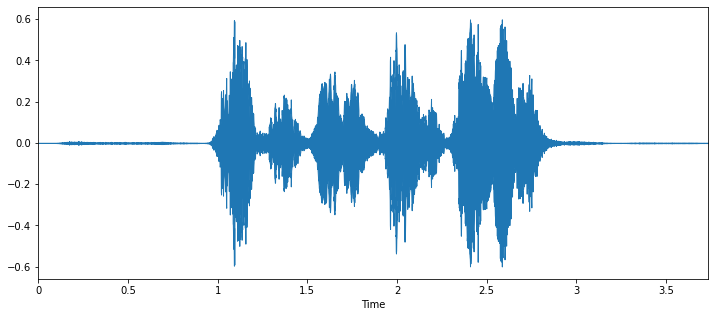

In [146]:
# AUDIO WITH PITCH
x = pitch(data, sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

After listening to all augmented audio, it's decided to use noise, stretch and pitch for augmenting data.

# FEATURE EXTRACTION

In [ ]:

def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [ ]:
RAV_df.head()

In [ ]:
X, Y = [], []
for path, emotion in zip(RAV_df['path'], RAV_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

In [152]:
# can use this directly from saved feature .csv file
Features = pd.read_csv('../input/features/features.csv')
Features.head()

0           1          2          3          4         5  \
0 -637.701233  104.299019   4.894947  20.494011  12.552954  2.851410   
1 -596.908460   86.871936   9.470162  17.109819  11.198966  1.541056   
2 -698.086548   99.795929   1.892679  19.915264   7.532868  1.265761   
3 -279.141052   41.092949 -21.319229   7.802911 -13.140503 -9.407660   
4 -160.074686   17.576058  -2.147436   3.133417  -4.745002 -6.510771   

           6         7          8         9  ...         11        12  \
0  -6.633390 -4.091278 -10.423918 -6.406950  ...   0.172893 -1.170210   
1  -6.677264 -5.755428  -9.684472 -6.891256  ...   0.033803 -1.986515   
2  -9.188656 -5.798194 -12.299710 -4.976400  ...  -1.639542 -2.603761   
3 -15.580647 -6.097223 -24.700903 -9.640293  ... -10.305976 -4.092835   
4  -5.911591 -4.481506  -9.470598 -5.907823  ...  -4.088007 -1.817639   

         13         14        15         16        17        18        19  \
0 -5.292450  -0.573319  1.019471  -3.492607 -3.468123 -1.214944  1.971239   
1 -5.103855  -1.253110  0.514896  -3.268317 -4.502895  0.167153  0.256732   
2 -4.890347  -0.879222 -1.250208  -3.449960 -4.708529 -0.086224 -3.034044   
3 -5.817179 -10.731523 -0.823596 -15.885103 -2.014258 -6.173852 -5.331760   
4 -2.994765  -4.893176 -2.880436  -7.163400 -2.147345 -2.359248 -3.746217   

       labels  
0   male_calm  
1   male_calm  
2   male_calm  
3  male_angry  
4  male_angry  

[5 rows x 21 columns]

# DATA PREPROCESSING

In [153]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [154]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [155]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 16), (1080, 20), (1080, 16))

In [156]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 16), (1080, 20), (1080, 16))

# IMPLOYING MODELS

## **KNN**

In [157]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=3)
clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [158]:
y_pred=clf1.predict(x_test)

In [159]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.856
Test set score: 0.626


## **MLP CLASSIFIER**

In [160]:
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=400)
clf2.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=400)

In [161]:
y_pred=clf2.predict(x_test)

In [162]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

Training set score: 0.914
Test set score: 0.602


## **CNN**

In [75]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3240, 20, 1), (3240, 16), (1080, 20, 1), (1080, 16))

In [76]:
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 20, 2048)          12288     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 2048)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 2048)          8192      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 1024)          10486784  
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 1024)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 1024)           4096      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 512)           

In [77]:
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
51/51 [==============================] - 7s 45ms/step - loss: 2.7636 - accuracy: 0.0759 - val_loss: 2.7712 - val_accuracy: 0.0528
Epoch 2/200
51/51 [==============================] - 1s 29ms/step - loss: 2.7383 - accuracy: 0.0843 - val_loss: 2.7702 - val_accuracy: 0.0750
Epoch 3/200
51/51 [==============================] - 1s 29ms/step - loss: 2.7135 - accuracy: 0.0992 - val_loss: 2.7723 - val_accuracy: 0.0759
Epoch 4/200
51/51 [==============================] - 1s 28ms/step - loss: 2.6750 - accuracy: 0.1296 - val_loss: 2.7729 - val_accuracy: 0.0546
Epoch 5/200
51/51 [==============================] - 1s 29ms/step - loss: 2.6170 - accuracy: 0.1647 - val_loss: 2.7687 - val_accuracy: 0.1306
Epoch 6/200
51/51 [==============================] - 1s 29ms/step - loss: 2.5511 - accuracy: 0.1618 - val_loss: 2.7583 - val_accuracy: 0.1352
Epoch 7/200
51/51 [==============================] - 1s 28ms/step - loss: 2.4947 - accuracy: 0.1856 - val_loss: 2.7051 - val_accuracy: 0.1102
Epoch 

In [78]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 7ms/step - loss: 1.6822 - accuracy: 0.8157
Accuracy of our model on test data :  81.57407641410828 %


Since we got the best accuracy with the cnn model we will further be using it.

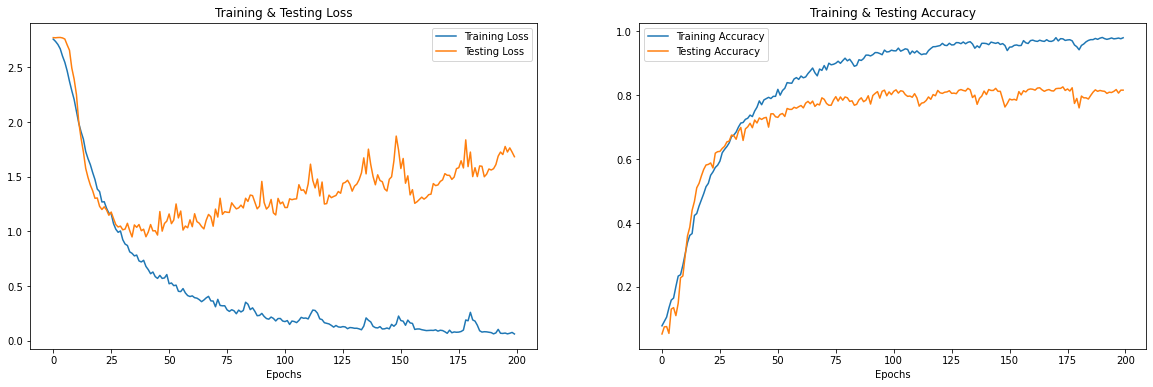

In [79]:
epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [80]:
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels    Actual Labels
0     female_angry     female_angry
1         male_sad         male_sad
2  female_surprise     female_angry
3      female_calm      female_calm
4      female_calm      female_calm
5  female_surprise  female_surprise
6         male_sad         male_sad
7       male_happy       male_happy
8   female_disgust   female_disgust
9        male_fear        male_fear

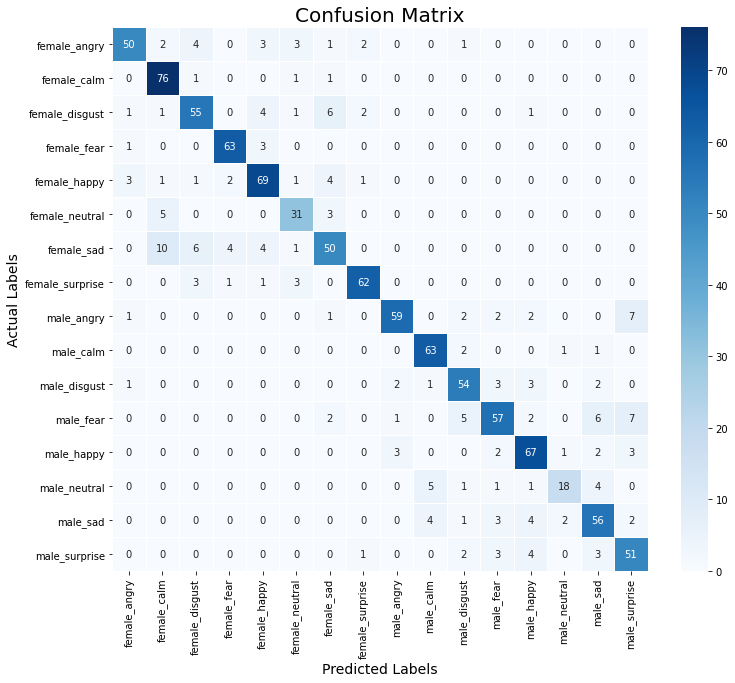

In [81]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## **SAVING THE MODEL**

In [82]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working/saved_models/Emotion_Voice_Detection_Model.h5 


In [83]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [85]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")

Loaded model from disk


# LIVE DEMO

In [86]:
data, sampling_rate = librosa.load('../input/output/output10.wav')

In [104]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

UsageError: Line magic function `%` not found.


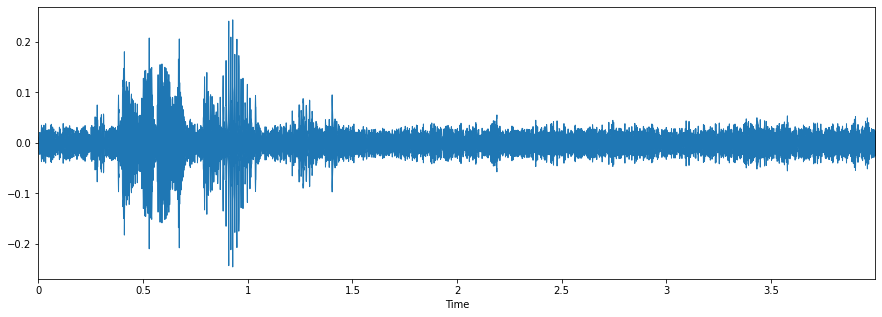

In [105]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [106]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('../input/output/output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [107]:
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
livedf2

0        1          2          3          4         5          6    \
          0        0          0          0          0         0          0   
0 -10.59606 -8.94651 -10.528727 -13.296783 -14.177726 -13.25804 -13.502741   

         7          8          9    ...        206        207        208  \
           0          0          0  ...          0          0          0   
0 -11.362019 -10.019709 -12.648233  ... -11.578986 -12.063128 -12.182923   

         209        210        211        212        213        214        215  
           0          0          0          0          0          0          0  
0 -12.072397 -13.011659 -12.680104 -14.369738 -13.681639 -12.795549 -13.263432  

[1 rows x 216 columns]

In [108]:
twodim= np.expand_dims(livedf2, axis=2)

In [109]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 20ms/step


In [110]:
livepreds

array([[6.4453925e-06, 9.9825400e-01, 1.7311157e-03, 1.3834527e-08,
        2.2961961e-09, 5.0229163e-09, 4.0897402e-07, 5.1451820e-12,
        7.9499105e-06, 5.4134780e-08, 8.9322988e-08, 5.0213275e-12,
        1.9939778e-08, 6.9442380e-10, 7.9007268e-16, 6.8415933e-12]],
      dtype=float32)

In [126]:
livepreds.shape

(1, 16)

In [127]:
livepredictions = (encoder.inverse_transform((livepreds)))
livepredictions

array([['female_calm']], dtype=object)